In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.stats import skew

file_path = 'Downloads/SVM_dataset.csv'
df = pd.read_csv(file_path, delimiter=',')

print(df.head())

df.info()

print(df.isnull().sum())



         x1        x2          x3        x4        x5        x6        x7  \
0  1.205492  5.823226   98.837539 -1.075852  0.999205  0.911543  3.623558   
1  1.391530  3.611581   98.857197 -5.020318  0.677165  0.999492  3.413112   
2  1.692571 -0.887019  100.901276 -0.595548  0.177550 -0.915495  4.320264   
3  4.289320  1.416843  100.784735 -2.897154 -0.066972 -0.786173  2.093003   
4  0.542420 -1.010095  100.015580 -3.070705  0.088324 -0.242669  0.767942   

         x8        x9        x10  y  
0 -1.720267 -0.346191 -54.708330 -1  
1  4.253865  2.041603 -54.317291  1  
2  0.907834  3.126815 -56.397484 -1  
3  1.336237  2.183829 -56.197728  1  
4 -0.284683 -2.104145 -55.794045  1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   x4      100

Shape of the cleaned DataFrame after removing outliers: (9406, 11)
Skewness of each feature:
 x3     0.102010
y      0.071927
x2     0.033562
x9     0.023443
x1     0.021593
x8     0.002468
x4    -0.005514
x7    -0.043791
x6    -0.101650
x10   -0.105321
x5    -0.187200
dtype: float64


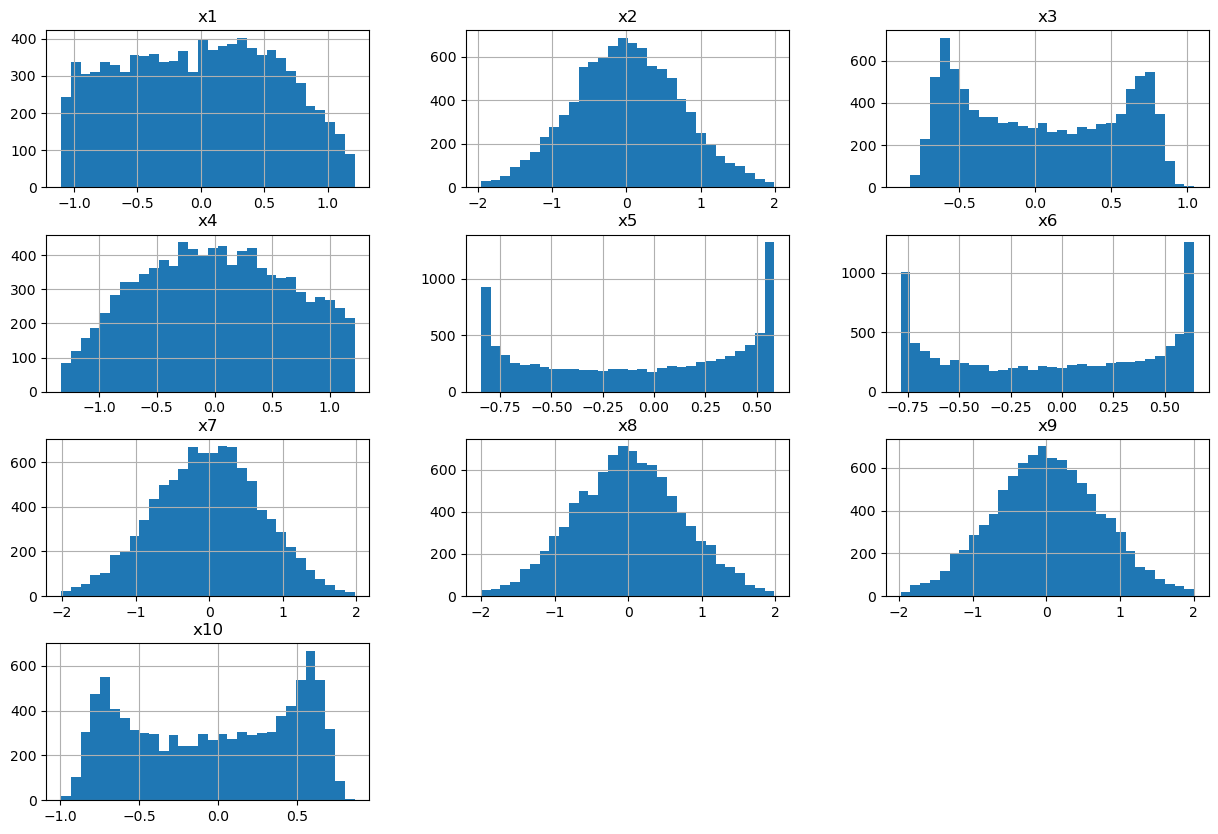

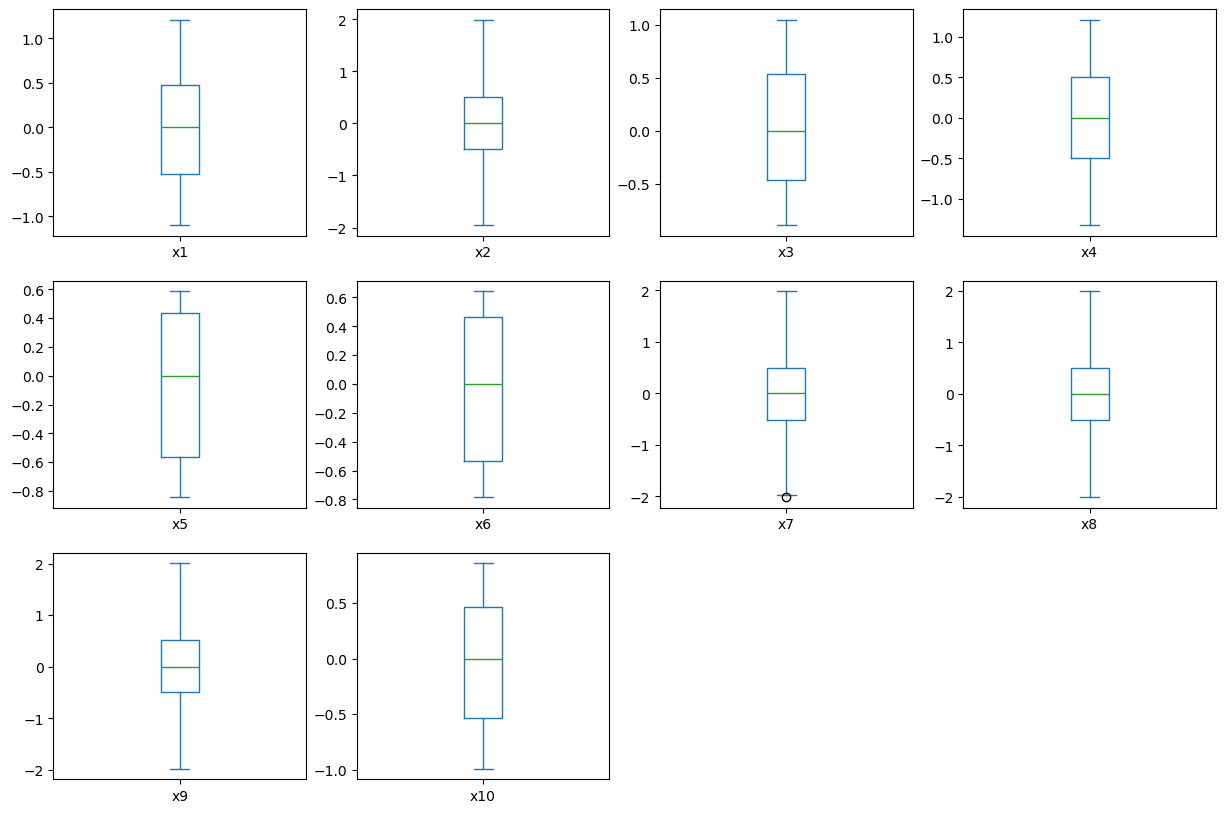

In [127]:
from sklearn.preprocessing import PowerTransformer

for column in df.columns:
    if column != 'y': 
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Shape of the cleaned DataFrame after removing outliers: {df.shape}")

skewness = df.skew().sort_values(ascending=False)
print("Skewness of each feature:\n", skewness)

X = df.drop('y', axis=1)
y = df['y']
pt = PowerTransformer(method='yeo-johnson')
df['x4'] = pt.fit_transform(df[['x4']])
# Apply RobustScaler
scaler = RobustScaler()
X_robust_scaled = scaler.fit_transform(X)

X_robust_scaled = pd.DataFrame(X_robust_scaled, columns=X.columns)
X_robust_scaled.hist(bins=30, figsize=(15,10))
plt.show()

X_robust_scaled.plot(kind='box', subplots=True, layout=(3,4), figsize=(15,10), sharex=False, sharey=False)
plt.show()

In [164]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_robust_scaled.values, y, test_size=0.2,random_state=42)
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        y_ = np.where(y <= 0, -1, 1)
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = np.sign(linear_output)
                
                # Perceptron update rule
                update = self.learning_rate * (y_[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update
    
    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = np.sign(linear_output)
        return y_predicted



perceptron = Perceptron(learning_rate=0.01, n_iters=1000)

perceptron.fit(X_train, y_train)

predictions = perceptron.predict(X_test)

accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 63.92%


In [165]:
import numpy as np

class PegasosSVM:
    def __init__(self, lambda_param=0.01, max_iter=1000):
        self.lambda_param = lambda_param
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for t in range(1, self.max_iter + 1):
            i = np.random.randint(0, n_samples)
            xi = X[i]
            yi = y[i]

            eta = 1 / (self.lambda_param * t)

            if yi * (np.dot(xi, self.w) + self.b) < 1:
                self.w = (1 - eta * self.lambda_param) * self.w + eta * yi * xi
                self.b += eta * yi
            else:
                self.w = (1 - eta * self.lambda_param) * self.w

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

X = X_robust_scaled.values
y = df['y'].values

y = np.where(y == 1, 1, -1)

pegasos_svm = PegasosSVM(lambda_param=0.01, max_iter=1000)
pegasos_svm.fit(X, y)

predictions = pegasos_svm.predict(X_test)

accuracy = np.mean(predictions == y_test)
print(f"Pegasos SVM model accuracy: {accuracy * 100:.2f}%")


Pegasos SVM model accuracy: 73.17%


In [161]:
class PegasosLogisticRegression:
    def __init__(self, lambda_param=0.01, max_iter=1000):
        self.lambda_param = lambda_param
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for t in range(1, self.max_iter + 1):
            i = np.random.randint(0, n_samples)
            xi = X[i]
            yi = y[i]
            eta = 1 / (self.lambda_param * t)

            margin = yi * (np.dot(xi, self.w) + self.b)
            gradient = self._sigmoid(-margin)

            self.w = (1 - eta * self.lambda_param) * self.w + eta * gradient * yi * xi
            self.b += eta * gradient * yi

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        return np.where(self._sigmoid(linear_output) >= 0.5, 1, -1)

pegasos_log_reg = PegasosLogisticRegression(lambda_param=0.01, max_iter=1000)
pegasos_log_reg.fit(X, y)

log_reg_predictions = pegasos_log_reg.predict(X_test)

log_reg_accuracy = np.mean(log_reg_predictions == y_test)
print(f"Pegasos Logistic Regression model accuracy: {log_reg_accuracy * 100:.2f}%")


Pegasos Logistic Regression model accuracy: 70.40%


In [170]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

pegasos_svm_poly = PegasosSVM(lambda_param=0.01, max_iter=10000)
pegasos_svm_poly.fit(X_train, y_train)

svm_poly_predictions = pegasos_svm_poly.predict(X_test)

svm_poly_accuracy = np.mean(svm_poly_predictions == y_te)
print(f"Pegasos SVM with polynomial features accuracy on test data: {svm_poly_accuracy * 100:.2f}%")

pegasos_log_reg_poly = PegasosLogisticRegression(lambda_param=0.01, max_iter=10000)
pegasos_log_reg_poly.fit(X_train, y_train)

log_reg_poly_predictions = pegasos_log_reg_poly.predict(X_test)

log_reg_poly_accuracy = np.mean(log_reg_poly_predictions == y_test)
print(f"Pegasos Logistic Regression with polynomial features accuracy on test data: {log_reg_poly_accuracy * 100:.2f}%")


Pegasos SVM with polynomial features accuracy on test data: 92.83%
Pegasos Logistic Regression with polynomial features accuracy on test data: 91.29%


In [171]:
svm_weights = pegasos_svm_poly.w

feature_names = poly.get_feature_names_out(X_robust_scaled.columns)

svm_weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': svm_weights})
svm_weights_df.sort_values(by='Weight', ascending=False, inplace=True)

print("Pegasos SVM weights with polynomial features:")
svm_weights_df.head(10)  # Display top 10 features


Pegasos SVM weights with polynomial features:


,Feature,Weight
27,x2 x9,3.096803
7,x8,1.394944
17,x1 x8,1.086258
4,x5,0.819427
6,x7,0.580294
0,x1,0.526455
8,x9,0.474750
20,x2^2,0.360041
46,x5 x7,0.253900
38,x4 x5,0.211230


In [172]:
log_reg_weights = pegasos_log_reg_poly.w

log_reg_weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': log_reg_weights})
log_reg_weights_df.sort_values(by='Weight', ascending=False, inplace=True)

print("Pegasos Logistic Regression weights with polynomial features:")
log_reg_weights_df.head(10) 


Pegasos Logistic Regression weights with polynomial features:


,Feature,Weight
27,x2 x9,2.858889
7,x8,1.484075
17,x1 x8,1.006808
4,x5,0.790127
0,x1,0.695135
6,x7,0.578281
20,x2^2,0.562657
8,x9,0.430070
11,x1 x2,0.385786
62,x9^2,0.346695


In [180]:
import numpy as np

class KernelPerceptron:
    def __init__(self, kernel, learning_rate=1.0, max_iter=1000):
        self.kernel = kernel
        self.lr = learning_rate
        self.max_iter = max_iter
        self.alphas = None
        self.bias = 0
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.alphas = np.zeros(n_samples)
        self.X_train = X
        self.y_train = y

        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        for _ in range(self.max_iter):
            for i in range(n_samples):
                kernel_sum = np.dot(self.alphas * y, kernel_matrix[i, :])
                if y[i] * (kernel_sum + self.bias) <= 0:
                    self.alphas[i] += self.lr
                    self.bias += self.lr * y[i]

    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            kernel_sum = 0
            for j in range(len(self.alphas)):
                kernel_sum += self.alphas[j] * self.y_train[j] * self.kernel(X[i], self.X_train[j])
            y_pred[i] = np.sign(kernel_sum + self.bias)
        return y_pred

def rbf_kernel(x, y, gamma=0.1):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

subset_size = 1000  
X_subset = X[:subset_size]
y_subset = y[:subset_size]

X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

kernel_perceptron_rbf = KernelPerceptron(kernel=rbf_kernel, max_iter=100)
kernel_perceptron_rbf.fit(X_train, y_train)

predictions_rbf = kernel_perceptron_rbf.predict(X_test)

accuracy_rbf = np.mean(predictions_rbf == y_test)
print(f"Kernelized Perceptron with RBF kernel accuracy on test data: {accuracy_rbf * 100:.2f}%")


Kernelized Perceptron with RBF kernel accuracy on test data: 93.00%


In [181]:
import numpy as np
from sklearn.model_selection import train_test_split

def grid_search_kernel_perceptron_with_subset_size(X, y, subset_sizes, learning_rates, max_iters, gammas):
    best_accuracy = 0
    best_params = {}
    
    for subset_size in subset_sizes:
        # Select a subset of the data
        X_subset = X[:subset_size]
        y_subset = y[:subset_size]
        
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

        for lr in learning_rates:
            for max_iter in max_iters:
                for gamma in gammas:
                    def rbf_kernel(x, y, gamma=gamma):
                        return np.exp(-gamma * np.linalg.norm(x - y) ** 2)
                    
                    kernel_perceptron = KernelPerceptron(kernel=rbf_kernel, learning_rate=lr, max_iter=max_iter)
                    kernel_perceptron.fit(X_train, y_train)
                    
                    predictions = kernel_perceptron.predict(X_test)
                    
                    accuracy = np.mean(predictions == y_test)
                    print(f"Accuracy: {accuracy * 100:.2f}% - Subset: {subset_size}, LR: {lr}, Max Iter: {max_iter}, Gamma: {gamma}")
                    
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {'subset_size': subset_size, 'learning_rate': lr, 'max_iter': max_iter, 'gamma': gamma}
    
    return best_params, best_accuracy

subset_sizes = [500, 1000]  
learning_rates = [0.1, 0.05]
max_iters = [100,250,500]
gammas = [0.01, 0.1]

best_params, best_accuracy = grid_search_kernel_perceptron_with_subset_size(X, y, subset_sizes, learning_rates, max_iters, gammas)

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy * 100:.2f}%")


Accuracy: 68.00% - Subset: 500, LR: 0.1, Max Iter: 100, Gamma: 0.01
Accuracy: 91.00% - Subset: 500, LR: 0.1, Max Iter: 100, Gamma: 0.1
Accuracy: 76.00% - Subset: 500, LR: 0.1, Max Iter: 250, Gamma: 0.01
Accuracy: 91.00% - Subset: 500, LR: 0.1, Max Iter: 250, Gamma: 0.1
Accuracy: 82.00% - Subset: 500, LR: 0.1, Max Iter: 500, Gamma: 0.01
Accuracy: 91.00% - Subset: 500, LR: 0.1, Max Iter: 500, Gamma: 0.1
Accuracy: 68.00% - Subset: 500, LR: 0.05, Max Iter: 100, Gamma: 0.01
Accuracy: 91.00% - Subset: 500, LR: 0.05, Max Iter: 100, Gamma: 0.1
Accuracy: 76.00% - Subset: 500, LR: 0.05, Max Iter: 250, Gamma: 0.01
Accuracy: 91.00% - Subset: 500, LR: 0.05, Max Iter: 250, Gamma: 0.1
Accuracy: 82.00% - Subset: 500, LR: 0.05, Max Iter: 500, Gamma: 0.01
Accuracy: 91.00% - Subset: 500, LR: 0.05, Max Iter: 500, Gamma: 0.1
Accuracy: 86.50% - Subset: 1000, LR: 0.1, Max Iter: 100, Gamma: 0.01
Accuracy: 93.00% - Subset: 1000, LR: 0.1, Max Iter: 100, Gamma: 0.1
Accuracy: 89.50% - Subset: 1000, LR: 0.1, Max I

In [183]:
kernel_perceptron_rbf_full = KernelPerceptron(kernel=rbf_kernel, max_iter=1000)
kernel_perceptron_rbf_full.fit(X_train, y_train)

predictions_rbf_full = kernel_perceptron_rbf_full.predict(X_test)

accuracy_rbf_full = np.mean(predictions_rbf_full == y_test)
print(f"Kernelized Perceptron with RBF kernel accuracy on full dataset: {accuracy_rbf_full * 100:.2f}%")


Kernelized Perceptron with RBF kernel accuracy on full dataset: 95.50%


In [191]:
import numpy as np

class KernelPegasosSVM:
    def __init__(self, lambda_param=0.1, max_iter=1000, kernel='rbf', degree=2, gamma=0.1):
        self.lambda_param = lambda_param
        self.max_iter = max_iter
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alphas = None
        self.X_train = None
        self.y_train = None

    def _rbf_kernel(self, x, y):
        return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)

    def _polynomial_kernel(self, x, y):
        return (np.dot(x, y) + 1) ** self.degree

    def _kernel_function(self, x, y):
        if self.kernel == 'rbf':
            return self._rbf_kernel(x, y)
        elif self.kernel == 'poly':
            return self._polynomial_kernel(x, y)
        else:
            raise ValueError("Unknown kernel type. Supported types are 'rbf' and 'poly'.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alphas = np.zeros(n_samples)
        self.X_train = X
        self.y_train = y

        for t in range(1, self.max_iter + 1):
            # Pick a random sample
            i = np.random.randint(0, n_samples)
            xi = X[i]
            yi = y[i]

            # Learning rate decreases over time
            eta = 1 / (self.lambda_param * t)

            # Compute kernel sum
            kernel_sum = sum(self.alphas[j] * self.y_train[j] * self._kernel_function(self.X_train[j], xi) for j in range(n_samples))

            # Pegasos update rule
            if yi * kernel_sum < 1:
                self.alphas[i] = (1 - eta * self.lambda_param) * self.alphas[i] + eta * yi
            else:
                self.alphas[i] = (1 - eta * self.lambda_param) * self.alphas[i]

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            kernel_sum = sum(self.alphas[j] * self.y_train[j] * self._kernel_function(self.X_train[j], X[i]) for j in range(len(self.alphas)))
            y_pred[i] = np.sign(kernel_sum)
        return y_pred


kernel_pegasos_rbf = KernelPegasosSVM(kernel='rbf', max_iter=1000, gamma=0.1)
kernel_pegasos_rbf.fit(X_train, y_train)

predictions_rbf = kernel_pegasos_rbf.predict(X_test)

accuracy_rbf = np.mean(predictions_rbf == y_test)
print(f"Kernelized Pegasos SVM with RBF kernel accuracy: {accuracy_rbf * 100:.2f}%")

kernel_pegasos_poly = KernelPegasosSVM(kernel='poly', max_iter=1000, degree=2)
kernel_pegasos_poly.fit(X_train, y_train)

predictions_poly = kernel_pegasos_poly.predict(X_test)

accuracy_poly = np.mean(predictions_poly == y_test)
print(f"Kernelized Pegasos SVM with Polynomial kernel accuracy: {accuracy_poly * 100:.2f}%")


Kernelized Pegasos SVM with RBF kernel accuracy: 48.19%
Kernelized Pegasos SVM with Polynomial kernel accuracy: 48.19%


In [194]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class KernelPegasosSVM:
    def __init__(self, lambda_param=0.01, max_iter=1000, kernel='rbf', degree=3, gamma=0.1):
        self.lambda_param = lambda_param
        self.max_iter = max_iter
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alphas = None
        self.X_train = None
        self.y_train = None

    def _rbf_kernel(self, x, y):
        return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)

    def _polynomial_kernel(self, x, y):
        return (np.dot(x, y) + 1) ** self.degree

    def _kernel_function(self, x, y):
        if self.kernel == 'rbf':
            return self._rbf_kernel(x, y)
        elif self.kernel == 'poly':
            return self._polynomial_kernel(x, y)
        else:
            raise ValueError("Unknown kernel type. Supported types are 'rbf' and 'poly'.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alphas = np.zeros(n_samples)
        self.X_train = X
        self.y_train = y

        for t in range(1, self.max_iter + 1):
            i = np.random.randint(0, n_samples)
            xi = X[i]
            yi = y[i]

            eta = 1 / (self.lambda_param * t)

            kernel_sum = sum(self.alphas[j] * self.y_train[j] * self._kernel_function(self.X_train[j], xi) for j in range(n_samples))

            if yi * kernel_sum < 1:
                self.alphas[i] = (1 - eta * self.lambda_param) * self.alphas[i] + eta * yi
            else:
                self.alphas[i] = (1 - eta * self.lambda_param) * self.alphas[i]

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            kernel_sum = sum(self.alphas[j] * self.y_train[j] * self._kernel_function(self.X_train[j], X[i]) for j in range(len(self.alphas)))
            y_pred[i] = np.sign(kernel_sum)
        return y_pred

class CustomGridSearchCV:
    def __init__(self, estimator_class, param_grid, scoring, cv=3):
        self.estimator_class = estimator_class
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.best_params_ = None
        self.best_score_ = None

    def fit(self, X, y):
        best_score = -np.inf
        best_params = None

        for params in self._param_combinations(self.param_grid):
            scores = []

            for train_idx, val_idx in self._kfold_split(X, y, self.cv):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                # Initialize the estimator with the current set of parameters
                estimator = self.estimator_class(**params)
                estimator.fit(X_train, y_train)
                y_pred = estimator.predict(X_val)

                score = self.scoring(y_val, y_pred)
                scores.append(score)

            avg_score = np.mean(scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = params

        self.best_params_ = best_params
        self.best_score_ = best_score
        return self

    def _param_combinations(self, param_grid):
        from itertools import product
        keys, values = zip(*param_grid.items())
        for combo in product(*values):
            yield dict(zip(keys, combo))

    def _kfold_split(self, X, y, k):
        n_samples = len(y)
        fold_size = n_samples // k
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        for i in range(k):
            val_idx = indices[i * fold_size: (i + 1) * fold_size]
            train_idx = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
            yield train_idx, val_idx

param_grid_rbf = {
    'lambda_param': [0.001, 0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1, 1.0],
    'max_iter': [500, 1000, 2000]
}
param_grid_poly = {
    'lambda_param': [0.001, 0.01, 0.1],
    'degree': [2, 3, 4],
    'max_iter': [500, 1000, 2000]
}

grid_search_rbf = CustomGridSearchCV(KernelPegasosSVM, param_grid_rbf, scoring=accuracy_score)
grid_search_rbf.fit(X_train, y_train)
print(f"Best parameters for RBF kernel: {grid_search_rbf.best_params_}")
print(f"Best accuracy for RBF kernel: {grid_search_rbf.best_score_ * 100:.2f}%")

grid_search_poly = CustomGridSearchCV(KernelPegasosSVM, param_grid_poly, scoring=accuracy_score)
grid_search_poly.fit(X_train, y_train)
print(f"Best parameters for Polynomial kernel: {grid_search_poly.best_params_}")
print(f"Best accuracy for Polynomial kernel: {grid_search_poly.best_score_ * 100:.2f}%")

best_rbf_model = KernelPegasosSVM(kernel='rbf', **grid_search_rbf.best_params_)
best_rbf_model.fit(X_train, y_train)
test_predictions_rbf = best_rbf_model.predict(X_test)
test_accuracy_rbf = accuracy_score(y_test, test_predictions_rbf)
print(f"Test accuracy for RBF kernel with tuned parameters: {test_accuracy_rbf * 100:.2f}%")

best_poly_model = KernelPegasosSVM(kernel='poly', **grid_search_poly.best_params_)
best_poly_model.fit(X_train, y_train)
test_predictions_poly = best_poly_model.predict(X_test)
test_accuracy_poly = accuracy_score(y_test, test_predictions_poly)
print(f"Test accuracy for Polynomial kernel with tuned parameters: {test_accuracy_poly * 100:.2f}%")


Best parameters for RBF kernel: {'lambda_param': 0.001, 'gamma': 0.1, 'max_iter': 500}
Best accuracy for RBF kernel: 48.21%
Best parameters for Polynomial kernel: {'lambda_param': 0.001, 'degree': 2, 'max_iter': 500}
Best accuracy for Polynomial kernel: 48.21%
Test accuracy for RBF kernel with tuned parameters: 48.19%
Test accuracy for Polynomial kernel with tuned parameters: 48.19%
